In [1]:
from state_env import State
import pandas as pd
import numpy as np
import configparser
import matplotlib.pyplot as plt

# Assesment of noise model

In [10]:
noisy_env = State()  # noisy environment
ideal_env = State()  # ideal environment

number_of_episodes = 100

n8_noise_effects = pd.DataFrame(columns=['episode','noise_amplitude', 'noise_probability', 'max_fidelity'])    # we store the mean fidelity for each noise amplitude and probability
n8_noise_details = pd.DataFrame(columns=['episode','time_step','noise_amplitude', 'noise_probability', 'fid_value','inner_product'])

config = configparser.ConfigParser()
config.read("config.ini")  # read the configuration file

for noise_amplitude in np.linspace(0, 1, 21):
    for noise_probability in np.linspace(0, 1, 21):

        print(f"Testing with noise_amplitude: {noise_amplitude}, noise_probability: {noise_probability}")
        lth = config.getint("system_parameters", "max_t_steps")

        actionspace = []  # store successful actions
        Qvalue = []  # total reward
        fid_max_vector = []  # max. fidelity in each episode
        t_fid_max_vector = []  # time of max. fidelity
        fid_end_vector = []  # final fidelity
        t_end_vector = []  # time of final fidelity
        success_action_sequences = []  # store successful success_action_seq

        for episode in range(number_of_episodes):
            # Generate a complex normalized vector of 16 components
            noisy_observation = noisy_env.reset()
            ideal_observation = ideal_env.reset()
            
            evolution = []
            Q = 0
            fid_max = 0
            t_fid_max = 0

            for i in range(lth):  # episode maximum length
                # Use the loaded model to predict the action
                # Correct the shape of the noisy_observation before feeding it to the model

                noisy_observation_, reward, done, fidelity = noisy_env.noisy_step(0,noise_amplitude=noise_amplitude,noise_probability=noise_probability)  # take action in the noisy_environment
                ideal_observation_, reward_ideal, done_ideal, fidelity_ideal = ideal_env.step(0)  # take action in the ideal_environment

                Q += reward  # total reward
                
                evolution.append(fidelity)  # store fidelity values
                noisy_observation = noisy_observation_  # Update current state
                ideal_observation = ideal_observation_  # Update current state

                inner_product = np.vdot(noisy_observation, ideal_observation)


                n8_noise_details = pd.concat(
                    [
                        n8_noise_details,
                        pd.DataFrame(
                            {
                                "episode": [episode],
                                "time_step": [i],
                                "noise_amplitude": [noise_amplitude],
                                "noise_probability": [noise_probability],
                                "fid_value": [fidelity],
                                "inner_product": [inner_product],
                            }
                        ),
                    ],
                    ignore_index=True,
                )
            n8_noise_effects = pd.concat(
                [
                    n8_noise_effects,
                    pd.DataFrame(
                        {
                            "episode": [episode],
                            "noise_amplitude": [noise_amplitude],
                            "noise_probability": [noise_probability],
                            "max_fidelity": [max(evolution)],
                        }
                    ),
                ],
                ignore_index=True,
            )

Testing with noise_amplitude: 0.0, noise_probability: 0.0
Testing with noise_amplitude: 0.0, noise_probability: 0.05
Testing with noise_amplitude: 0.0, noise_probability: 0.1
Testing with noise_amplitude: 0.0, noise_probability: 0.15000000000000002
Testing with noise_amplitude: 0.0, noise_probability: 0.2
Testing with noise_amplitude: 0.0, noise_probability: 0.25
Testing with noise_amplitude: 0.0, noise_probability: 0.30000000000000004
Testing with noise_amplitude: 0.0, noise_probability: 0.35000000000000003
Testing with noise_amplitude: 0.0, noise_probability: 0.4
Testing with noise_amplitude: 0.0, noise_probability: 0.45
Testing with noise_amplitude: 0.0, noise_probability: 0.5
Testing with noise_amplitude: 0.0, noise_probability: 0.55
Testing with noise_amplitude: 0.0, noise_probability: 0.6000000000000001
Testing with noise_amplitude: 0.0, noise_probability: 0.65
Testing with noise_amplitude: 0.0, noise_probability: 0.7000000000000001
Testing with noise_amplitude: 0.0, noise_probab

KeyboardInterrupt: 

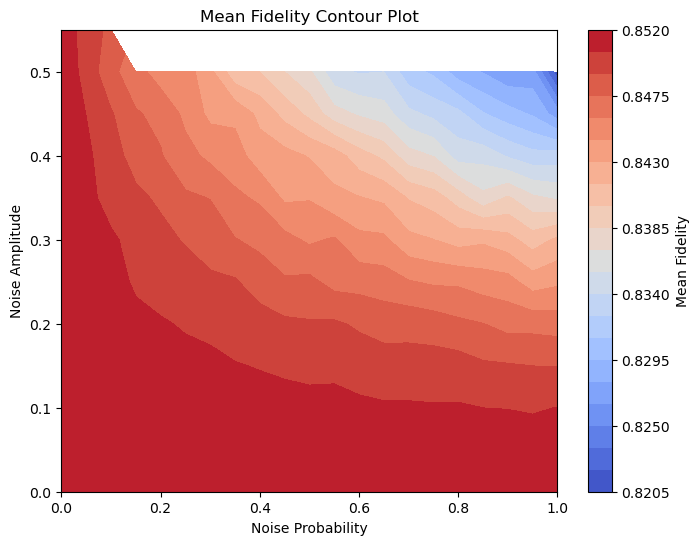

In [11]:
n8_noise_details.to_csv("n8_noise_details.csv", index=False)
n8_noise_effects.to_csv("n8_noise_effects.csv", index=False)

n8_stats = n8_noise_effects.groupby(
    ['noise_amplitude', 'noise_probability']
).agg(
    mean_fidelity=('max_fidelity', 'mean'),
).reset_index()


pivot_data = n8_stats.pivot(    
    index='noise_amplitude',
    columns='noise_probability',
    values='mean_fidelity'
)

X, Y = np.meshgrid(pivot_data.columns.values, pivot_data.index.values)
Z = pivot_data.values

plt.figure(figsize=(8, 6))
contour = plt.contourf(X, Y, Z, levels=25, cmap='coolwarm')

from scipy import stats

import matplotlib.pyplot as plt
plt.colorbar(contour, label='Mean Fidelity')
plt.xlabel('Noise Probability')
plt.ylabel('Noise Amplitude')
plt.title('Mean Fidelity Contour Plot')
plt.show()

In [12]:
n8_noise_details.head()

,episode,time_step,noise_amplitude,noise_probability,fid_value,inner_product
0,0,0,0.0,0.0,1.1442378906148648e-19,1.0
1,0,1,0.0,0.0,1.8502622546629546e-15,1.0
2,0,2,0.0,0.0,5.28443199063061e-13,1.0
3,0,3,0.0,0.0,2.876119112992991e-11,1.0
4,0,4,0.0,0.0,6.286021798685895e-10,1.0


In [13]:
n8_inner_product.head()

NameError: name 'n8_inner_product' is not defined

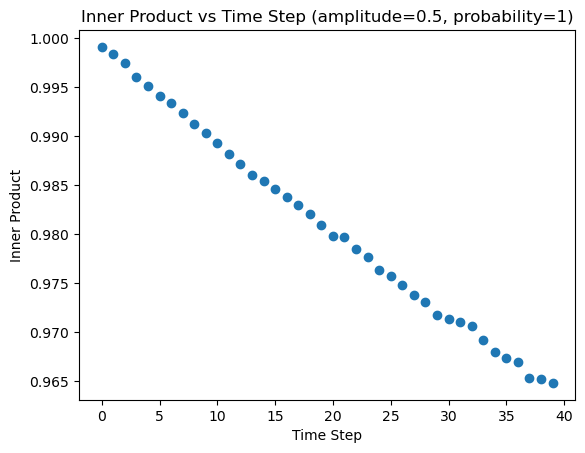

In [16]:
# Filter n8_noise_details for fixed noise_amplitude and noise_probability
fixed_amplitude = 0.5
fixed_probability = 1

n8_fixed_noise = n8_noise_details[
    (n8_noise_details['noise_amplitude'] == fixed_amplitude) &
    (n8_noise_details['noise_probability'] == fixed_probability)
]

# Average over episodes for each time_step
n8_fixed_noise = n8_fixed_noise.groupby('time_step').agg({
    'fid_value': 'mean',
    'inner_product': 'mean'
}).reset_index()


# Convert time_step to int if necessary

plt.scatter(n8_fixed_noise['time_step'], n8_fixed_noise['inner_product'])
plt.xlabel('Time Step')
plt.ylabel('Inner Product')
plt.title(f'Inner Product vs Time Step (amplitude={fixed_amplitude}, probability={fixed_probability})')
plt.show()